# Aplicaciones móviles: segmentación de usuarios y usuarias en función del comportamiento

Toma las acciones que los usuarios y las usuarias realizan en la aplicación para definir grupos que difieren en términos de métricas del producto (tasa de retención, tiempo dedicado a la aplicación, frecuencia de ocurrencia de eventos, conversión en el evento de destino, contacts_show).

- Lleva a cabo el análisis exploratorio de datos
- Segmenta a los usuarios y las usuarias en función de los eventos que completan
- Prueba las hipótesis estadísticas
    - Formula y prueba una hipótesis sobre la diferencia en la conversión en vistas de información de contacto entre quienes descargaron la aplicación de bing y quienes la descargaron de google. 
    - Formula una hipótesis estadística sobre los datos del dataset y pruébala.

## Descomposición

### Definir el objetivo

Que queremos conseguir y por qué?
 - Queremos diferenciar a los usuarios en funcion de los eventos que realizan dentro de la aplicación. Esto nos permitira analizar más detalladamente a cada tipo de usuario (métricas) y poder tomar decisiones de negocio de acorde (campañas, etc).

A quién va dirigido nuestro análisis?
 - Directivo/manager a cargo de tomar decisiones de negocio

Qué decisiones se tomarán a partir de análisis?
 - Se decidirán las acciones a tomar para mejorar las métricas de cada grupo de usuarios (conversión, KPIs, etc)
 

### Especificar Detalles

En cuántos grupos debemos dividir a los usuarios?
 - Depende de los datos
 - Métodos posibles: cluster, RFM, cohortes, LTV
 - Consultar articulos de la industria para comparar tasas de conversion
 
Existe alguna preferencia para la empresa respecto a donde descargan los usuarios la app (bing o google)?

Que se considera una buena conversión? que se considera una mala conversión?

Manejo de duplicados y valores ausentes
 - eliminar implicitos y explicitos para tener datos limpios y precisos
 
Buscamos una tasa de retencion mínima?
 - Buscar marco de referencia claro primero
 
Buscamos un mínimo tiempo de uso en la aplicación?
 - Buscar marco de referencia claro primero


### Proponer Hipótesis

- los usuarios de diferentes segmentos tienen diferente churn rate
- el churn rate difiere para usuarios que descargaron desde bing que desde google


### Plan de Acción

- Preprocesar los datos: ausentes, duplicados, nombres, tipos de dato, etc
- EDA: histogramas, datos atipicos, caracterisitcas de los datos, embudos, hipotesis iniciales, etc
- Clustering: dendograma, kmeans
- Pruebas de hipótesis: por source, por cluster
- Conclusiones (intermedias y finales)
- Presentación

## Preprocesamiento

In [1]:
# importamos librerias
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats as st

import seaborn as sns
import pandas as pd
import numpy as np
import math as mth

In [2]:
# estilo
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
# cargamos los datos
events = pd.read_csv("mobile_dataset_us.csv")
sources = pd.read_csv("mobile_sources_us.csv")

In [4]:
# mostramos las tablas
display(events.head())

display(sources.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,bing
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,bing
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


### Nombres de columnas 

In [5]:
# cambiamos nombres de columna
events.columns = events.columns.str.replace(".", "_")
sources = sources.rename(columns={"userId": "user_id"})

In [6]:
# mostramos info
events.info()

sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


### Tipos de dato

In [7]:
# mostramos valores unicos en tipos de evento
events["event_name"].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [8]:
# mostramos valores unicos en source
sources["source"].unique()

array(['other', 'bing', 'google'], dtype=object)

In [9]:
# cambiamos tipos de dato
events["event_time"] = pd.to_datetime(events["event_time"])

sources["source"] = sources["source"].astype("category")

In [10]:
# mostramos info
events.info()

sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   user_id  4293 non-null   object  
 1   source   4293 non-null   category
dtypes: category(1), object(1)
memory usage: 38.0+ KB


### Duplicados

In [11]:
# buscamos duplicados explicitos en events y sources
(events.duplicated().sum(), sources.duplicated().sum())

(np.int64(0), np.int64(0))

In [12]:
# buscamos duplicados en user_id
sources["user_id"].duplicated().sum()

np.int64(0)

In [13]:
# verificamos el numero de usuarios unicos
(events["user_id"].nunique(), sources["user_id"].nunique())

(4293, 4293)

### Conclusiones

- Se cambiaron los nombres de las columnas a unos mas apropiados
- Se cambiaron los tipos de dato a unos mas utiles
- No se encontraron valores duplicados
- Ambas tablas cuentan con el mismo numero de usuarios unicos

## EDA

### Tipos de evento

In [14]:
# mostramos cantidad de eventos por tipo
events["event_name"].value_counts(ascending=False)

event_name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: count, dtype: int64

In [15]:
# unificamos los eventos de search
events["name"] = events["event_name"].str.replace("search_\d", "search", regex=True)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\3376843013.py:2: SyntaxWarning: invalid escape sequence '\d'
  events['name'] = events['event_name'].str.replace('search_\d','search', regex=True)


In [16]:
# unificamos los eventos de mostrar contacto
events["name"] = events["name"].str.replace("show_contacts", "contacts_show")

In [17]:
# cambiamos a tipo de dato category
events["name"] = events["name"].astype("category")

In [18]:
# mostramos cantidad de eventos por tipo
events["name"].value_counts(ascending=False)

name
tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: count, dtype: int64

In [19]:
# cantidad total de eventos
total_events = events.shape[0]
total_events

74197

Contamos con un total de 74k eventos, divididos en 9 categorias. El evento mas popular es tips_show, mas este es un evento independiente de la actividad del usuario. Tomando esto en consideracion, el evento mas popular es photos_show con 10k eventos.

El evento de destino contacts_show esta en 5to lugar con 4500 eventos.

### Eventos por dia

In [20]:
# cantidad de dias de informacion
total_days = (events["event_time"].max() - events["event_time"].min()).days + 1
total_days

28

In [21]:
# creamos la columns date
events["date"] = events["event_time"].dt.date

In [22]:
# calculamos el numero de eventos por fecha y tipo de evento
events_date = (
    events.groupby(by=["date", "name"])
    .agg({"user_id": "count"})
    .reset_index()
    .rename(columns={"name": "event", "user_id": "n_events"})
)
events_date.head()

C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\3196134624.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_date = events.groupby(by=['date', 'name']).agg({'user_id': 'count'}).reset_index().rename(columns={'name': 'event', 'user_id': 'n_events'})


,date,event,n_events
0,2019-10-07,advert_open,401
1,2019-10-07,contacts_call,7
2,2019-10-07,contacts_show,61
3,2019-10-07,favorites_add,40
4,2019-10-07,map,168


In [23]:
# describimos los estadisticos diarios
events_date.groupby(by="date").agg({"n_events": "sum"}).describe()

,n_events
count,28.000000
mean,2649.892857
std,408.950358
min,1843.000000
25%,2457.000000
50%,2725.000000
75%,2884.750000
max,3361.000000


In [24]:
# promedio de eventos diaros
average_daily_events = (
    events_date.groupby(by="date").agg({"n_events": "sum"})["n_events"].mean()
)
average_daily_events

np.float64(2649.8928571428573)

Contamos con un promedio de entre 2600 a 2700 eventos diarios.

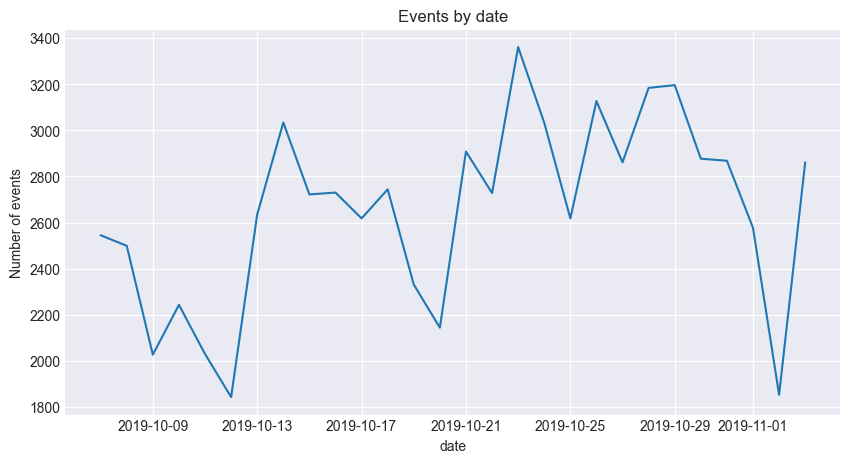

In [25]:
# mostramos cantidad de eventos por fecha
plt.figure(figsize=(10, 5))
sns.lineplot(data=events_date, x="date", y="n_events", estimator="sum", errorbar=None)

plt.ylabel("Number of events")
plt.title("Events by date")
plt.show()

El grafico nos muestra que existe mucha oscilacion entre la cantidad de eventos diarios (de 1800 a 3400). Por el analisis previo sabemos que existen eventos con muchas instancias.

Procedemos a diferenciar por tipo de evento.

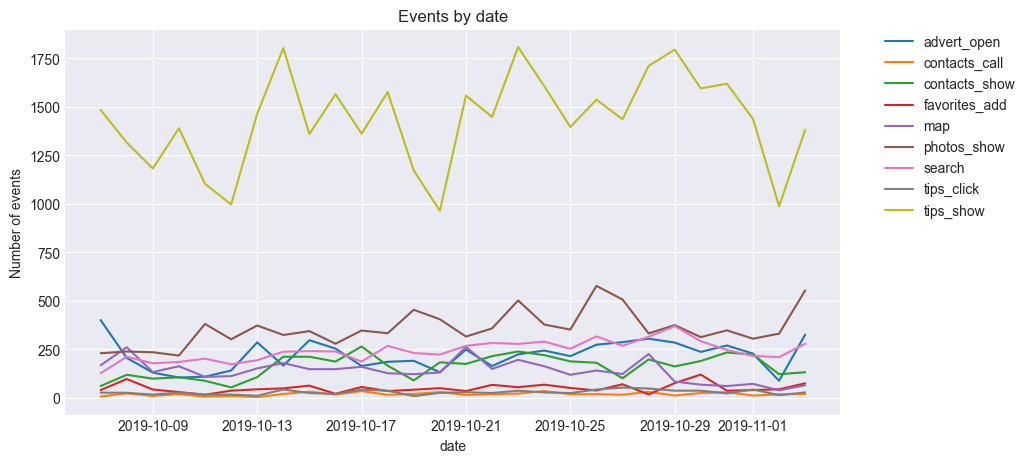

In [26]:
# mostramos cantidad de eventos por dia por tipo de evento
plt.figure(figsize=(10, 5))
sns.lineplot(data=events_date, x="date", y="n_events", hue="event", errorbar=None)

plt.ylabel("Number of events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Events by date")
plt.show()

Efectivamente, el evento de tips_show es bastante predominante y su forma domina la grafica de eventos totales por dia. Dado que este es el evento de mas alta frecuencia y que no depende de la actividad del usuario, podemos filtrarlo y analizar los otros eventos.

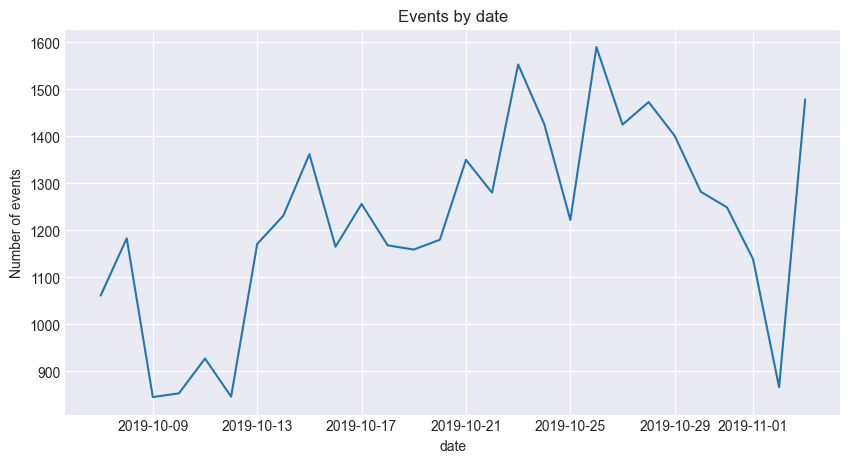

In [27]:
# mostramos cantidad de eventos por fecha sin tips_show
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=events_date[events_date["event"] != "tips_show"],
    x="date",
    y="n_events",
    estimator="sum",
    errorbar=None,
)

plt.ylabel("Number of events")
plt.title("Events by date")
plt.show()

In [28]:
# promedio real de eventos diaros
true_average_daily_events = (
    events_date[events_date["event"] != "tips_show"]
    .groupby(by="date")
    .agg({"n_events": "sum"})["n_events"]
    .mean()
)
true_average_daily_events

np.float64(1219.357142857143)

Sin contar tips_show, podemos tener una mejor percepcion del comportamiento de los usuarios. Vemos que la cantidad total de eventos diarios en realidad va desde alrededor de 800 hasta 1600, con un promedio de 1200 eventos diarios.

Nuevamente analizamos por tipo de evento.

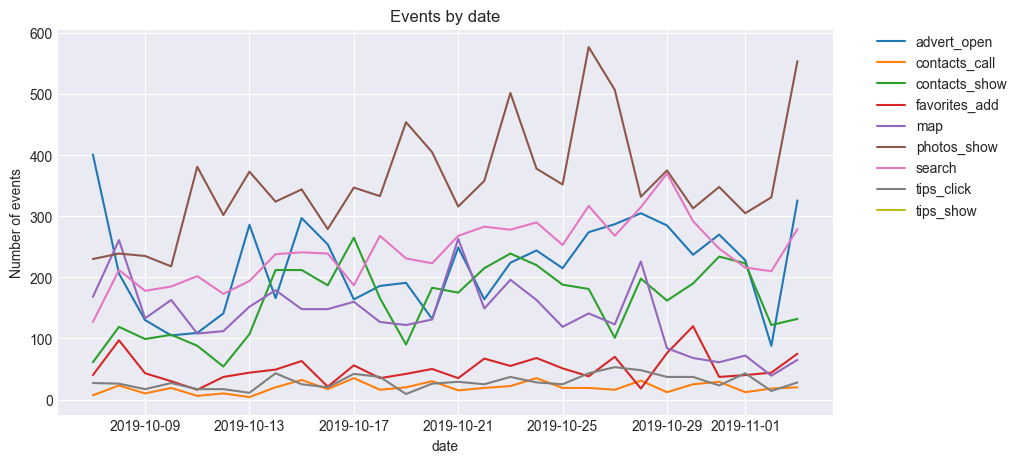

In [29]:
# mostramos la cantidad de eventos por dia por tipo de evento, sin tips_show
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=events_date[events_date["event"] != "tips_show"],
    x="date",
    y="n_events",
    hue="event",
    errorbar=None,
)

plt.ylabel("Number of events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Events by date")
plt.show()

Observamos que buena parte de los eventos cuentan con una frencuencia diaria de alrededor de 200. El evento photos_show se destaca como el evento mas frecuente. Los eventos tips_click, favorites_add y contacts call son los menos frecuentes con una frecuencia diaria aproximada de 50.

### Eventos por usuario

In [30]:
# agrupamos los eventos por usuario
events_user = (
    events.groupby(by="user_id")
    .agg({"name": "count"})
    .reset_index()
    .rename(columns={"name": "n_events"})
)
events_user.head()

,user_id,n_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8


In [31]:
# numero total de usuarios
total_users = events_user["user_id"].count()
total_users

np.int64(4293)

Contamos con un total de 4293 usuarios

In [32]:
# mostramos los estadisticos
events_user.describe()

,n_events
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


Vemos que existen datos atipicos, usuarios que realizan muchos eventos

In [33]:
# filtramos a los usuarios atipicos
percentile = np.percentile(events_user["n_events"], q=95)
percentile

np.float64(59.0)

In [34]:
# mostramos los estadisticos luego del filtro
events_user[events_user["n_events"] <= percentile].describe()

,n_events
count,4083.000000
mean,12.382072
std,10.693539
min,1.000000
25%,5.000000
50%,8.000000
75%,15.000000
max,59.000000


El usuario promedio realiza entre 8 a 12 eventos

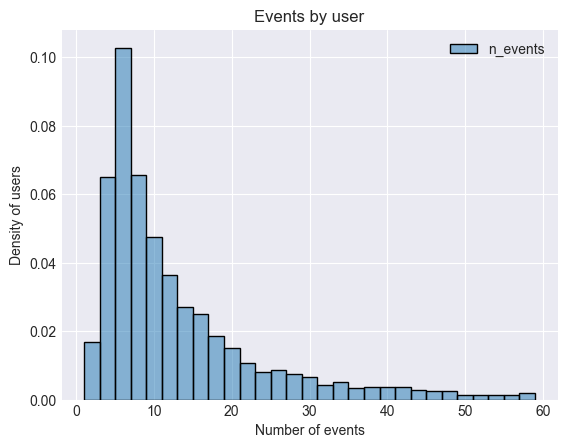

In [35]:
# mostramos el histograma de eventos por usuario
sns.histplot(
    data=events_user[events_user["n_events"] <= percentile], binwidth=2, stat="density"
)

plt.xlabel("Number of events")
plt.ylabel("Density of users")
plt.title("Events by user")
plt.show()

Del grafico podemos observar un claro sesgo hacia la derecha, con usuarios atipicos que realizan mas de 30 eventos. Los usuarios suelen realizar mas comunmente entre 3 a 8 eventos, con un pico entre 5 y 6 eventos.

### Usuarios activos

In [36]:
# calculamos numero de usuarios unicos por dia
dau = (
    events.groupby(by="date")
    .agg({"user_id": "nunique"})
    .reset_index()
    .rename(columns={"user_id": "n_users"})
)
dau.head()

,date,n_users
0,2019-10-07,204
1,2019-10-08,204
2,2019-10-09,227
3,2019-10-10,233
4,2019-10-11,206


In [37]:
# mostramos los estadisticos
dau.describe()

,n_users
count,28.000000
mean,279.178571
std,46.737291
min,178.000000
25%,238.250000
50%,292.500000
75%,310.500000
max,352.000000


In [38]:
# promedio de usuarios activos diarios
dau_mean = dau["n_users"].mean()
dau_mean

np.float64(279.17857142857144)

Contamos con un promedio de 279 usuarios activos diarios

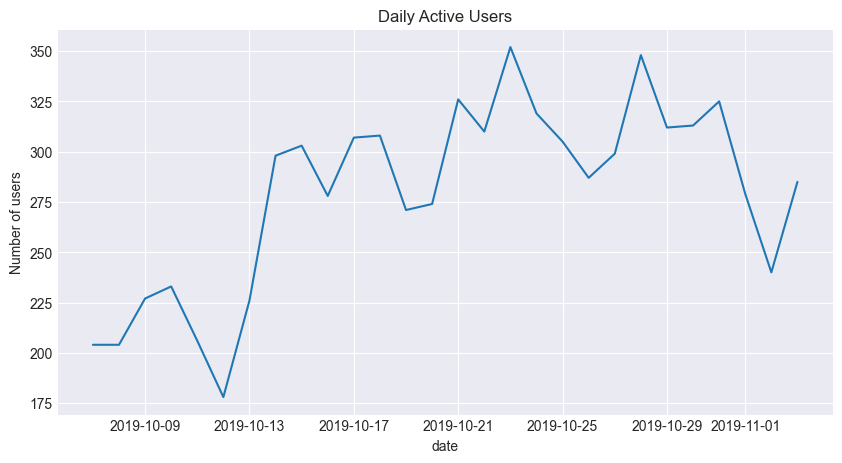

In [39]:
# graficamos el DAU
plt.figure(figsize=(10, 5))
sns.lineplot(data=dau, x="date", y="n_users")

plt.ylabel("Number of users")
plt.title("Daily Active Users")
plt.show()

Observamos que los primeros dias no habian mas de 240 usarios activos. Luego de una semana el numero sube alrededor de 300 DAU. 

In [40]:
# calculamos las semanas
events["week"] = events["event_time"].dt.isocalendar().week

In [41]:
# calculamos numero de usuarios unicos por dia
wau = (
    events.groupby(by="week")
    .agg({"user_id": "nunique"})
    .reset_index()
    .rename(columns={"user_id": "n_users"})
)
wau.head()

,week,n_users
0,41,1130
1,42,1438
2,43,1546
3,44,1416


In [42]:
# mostramos los estadisticos
wau["n_users"].describe()

count       4.000000
mean     1382.500000
std       177.661663
min      1130.000000
25%      1344.500000
50%      1427.000000
75%      1465.000000
max      1546.000000
Name: n_users, dtype: float64

In [43]:
# promedio de usuarios activos semanales
wau_mean = wau["n_users"].mean()
wau_mean

np.float64(1382.5)

Contamos con un promedio de 1382 usuarios activos semanales

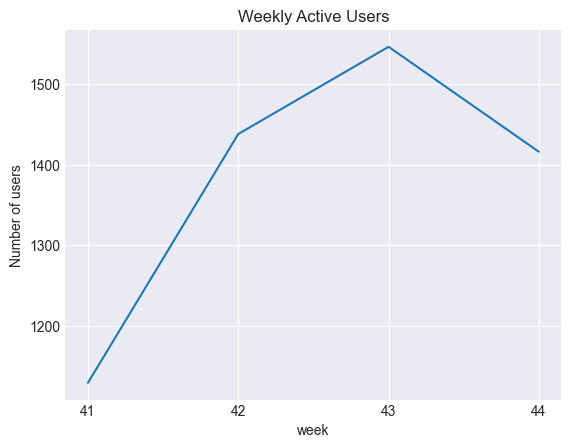

In [44]:
# graficamos el WAU
sns.lineplot(data=wau, x="week", y="n_users")

plt.xticks(labels=wau["week"], ticks=wau["week"])
plt.ylabel("Number of users")
plt.title("Weekly Active Users")
plt.show()

Conforme al grafico anterior, la primera semana contabamos con pocos usuarios activos. A partir de la segunda semana los numeros se estabilizan y se elevan por sobre los 1400 WAU

In [45]:
# sticky factor
sticky_factor_d = dau_mean / total_users * 100
sticky_factor_w = wau_mean / total_users * 100

print("Sticky Factor - Daily (%): ", sticky_factor_d)
print("Sticky Factor - Weekly (%): ", sticky_factor_w)

Sticky Factor - Daily (%):  6.503111377325214
Sticky Factor - Weekly (%):  32.20358723503377


Considerando a todos los usuarios como los MAU, nuestro sticky factor diario es del 7% y el sticky factor semanal es del 32%

### Embudo

In [46]:
# encontramos los usuarios unicos por evento
events.groupby(by="name").agg({"user_id": "nunique"}).sort_values(
    by="user_id", ascending=False
)

C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\4047983550.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events.groupby(by='name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)


,user_id
name,
tips_show,2801
search,1666
map,1456
photos_show,1095
contacts_show,981
advert_open,751
favorites_add,351
tips_click,322
contacts_call,213


Consideramos dos flujos:
 - tips_show -> tips_click -> contacts_show
 - search -> advert_open -> contacts_show

Procedemos a unificar estos flujos en uno solo:
 - tips_show + search-> tips_click + advert_open -> contacts_show
 - entrance_stage -> interaction_stage -> contacts_show

In [47]:
# unificamos los eventos de tips_show y search
events["funnel_stages"] = events["name"].str.replace("tips_show", "entrance_stage")
events["funnel_stages"] = events["funnel_stages"].str.replace(
    "search", "entrance_stage"
)

In [48]:
# unificamos los eventos de tips_click y search
events["funnel_stages"] = events["funnel_stages"].str.replace(
    "tips_click", "interaction_stage"
)
events["funnel_stages"] = events["funnel_stages"].str.replace(
    "advert_open", "interaction_stage"
)

In [49]:
# seleccionamos a los usuarios de interes
users_entrance_stage = events[events["funnel_stages"] == "entrance_stage"][
    "user_id"
].unique()
users_interaction_stage = events[events["funnel_stages"] == "interaction_stage"][
    "user_id"
].unique()
users_contact_show = events[events["funnel_stages"] == "contacts_show"][
    "user_id"
].unique()

In [50]:
# obtenemos los usuarios de la interaction_stage que no hayan pasado por entrance
users_interaction_no_entrance = list(
    set(users_interaction_stage) - set(users_entrance_stage)
)

# obtenemos los usuarios de contacts_show que no hayan pasado por interaction
users_contacts_no_interaction = list(
    set(users_contact_show) - set(users_interaction_stage)
)

In [51]:
# obtenemos los numeros de usuarios validos en cada etapa
entrance_stage_nusers = len(users_entrance_stage)
interaction_stage_nusers = len(users_interaction_stage) - len(
    users_interaction_no_entrance
)
contacts_show_nusers = len(users_contact_show) - len(users_contacts_no_interaction)

Teniendo el evento objetivo como contacts_show, consideramos que todos los usuarios deben haber primero visto un anuncio recomendado o buscado un anuncio.

Luego, los usuarios debieron o hacer click en el anuncio recomendado o abrir el anuncio buscado.

Finalmente, los usuarios dan click en mostrar contacto

El flujo considerado es entrance_stage -> interaction_stage -> contacts_show

In [52]:
# consideramos el flujo: search -> advert_open -> contacts_show
# graficamos el embudo
fig = go.Figure(
    go.Funnel(
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[entrance_stage_nusers, interaction_stage_nusers, contacts_show_nusers],
        textinfo="value+percent previous+percent initial",
    )
)

fig.show()

El embudo nos muestra que solo un 6% de los usuarios que realiza una busqueda o mira un auncio llega a hacer click en la informacion de contacto. Sin embargo, entre los usuarios que realizan busquedas o dan click a un anuncio, el 24% convierte.

### Conclusiones

- Se agruparon los eventos de una manera mas util para un mejor analisis
- Contamos con alrededor de 2700 eventos diarios de los cuales aproximadamente 1500 son tips_show
- Contamos con 4293 usuarios, de los cuales 210 son atipicos (top 5%)
- Los 4083 usuarios restantes realizan entre 3 a 8 (mediana) eventos
- Contamos con 279 usuarios activos diarios, 1382 usuarios activos semanales y 4293 usuarios activos mensuales (los datos son de 28 dias)
- El sticky factor diarios es de 6.5% y el semanal de 32.2%
- Solo 6% de los usuarios convierten al evento destino


## Hipotesis Iniciales

- diferencias con respecto a la fuente del usuario

### Eventos por dia

In [53]:
# mergeamos las tablas
events_sources = events.merge(sources, on="user_id", how="left")
events_sources.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,41,interaction_stage,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,tips_show,2019-10-07,41,entrance_stage,bing
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,advert_open,2019-10-07,41,interaction_stage,bing


In [54]:
# calculamos usuarios por fuente y eventos por fuente
users_events_by_source = (
    events_sources.groupby(by="source")
    .agg({"user_id": "nunique", "event_name": "count"})
    .reset_index()
    .rename(columns={"user_id": "n_users", "event_name": "n_events"})
)
users_events_by_source

C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\1865736476.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,source,n_users,n_events
0,bing,1934,34286
1,google,1129,20445
2,other,1230,19466


Vemos que google y other cuentan con una cantidad parecida de usuarios. Por otro lado, bing tiene casi un 60% mas de usuarios.

De la misma manera, other y google cuentan con una cantidad aproximada de eventos, mientras que bing cuenta con aprox. 70% mas de eventos.

Esto puede afectar nuestros resultados al momento de analizar las metricas.

In [55]:
# calculamos los eventos por dia por fuente
events_sources_date = (
    events_sources.groupby(by=["date", "source"])
    .agg({"user_id": "count"})
    .reset_index()
    .rename(columns={"user_id": "n_events"})
)
events_sources_date.head()

C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\1986371227.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,date,source,n_events
0,2019-10-07,bing,1249
1,2019-10-07,google,706
2,2019-10-07,other,590
3,2019-10-08,bing,1366
4,2019-10-08,google,591


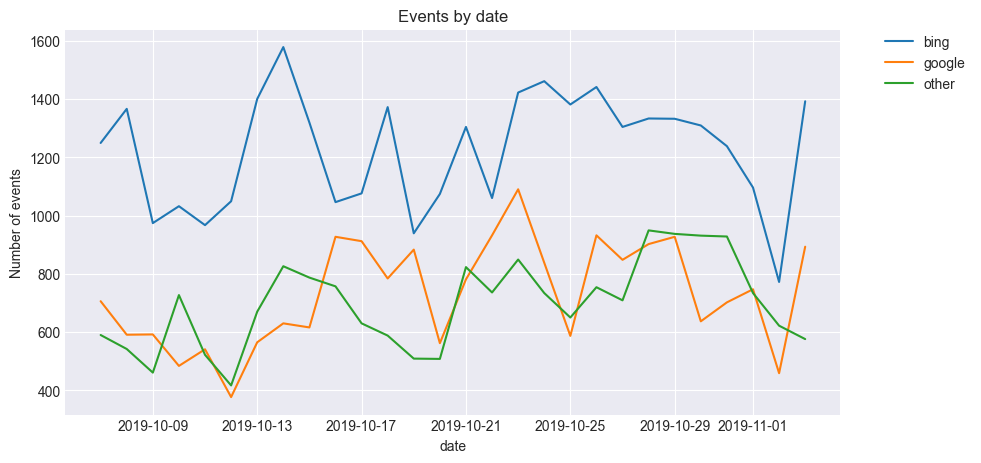

In [147]:
# graficamos cantidad de eventos por dia por fuente
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=events_sources_date,
    x="date",
    y="n_events",
    estimator="sum",
    errorbar=None,
    hue="source",
)

plt.ylabel("Number of events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Events by date")
plt.show()

Efectivamente, los usuarios que provienen de bing realizan una mayor cantidad de eventos por dia. Los que provienen de google o de otra fuente tienen un comportamiento similar.

Esto puede deberse a la mayor cantidad de usuarios provenientes de bing.

### Eventos por usuario

In [57]:
# calculamos la cantidad de eventos de cada usuario unico
event_sources_users = (
    events_sources.groupby(by=["user_id", "source"])
    .agg({"name": "count"})
    .reset_index()
    .rename(columns={"name": "n_events"})
)
event_sources_users = event_sources_users.drop(
    event_sources_users[event_sources_users["n_events"] == 0].index
).reset_index(drop=True)
event_sources_users.head()

C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\1866483015.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,user_id,source,n_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,bing,71
2,00463033-5717-4bf1-91b4-09183923b9df,bing,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,32
4,00551e79-152e-4441-9cf7-565d7eb04090,bing,8


In [58]:
# calculamos la cantidad promedio de eventos por usuario por fuente
users_events_by_source["events_per_user"] = (
    users_events_by_source["n_events"] / users_events_by_source["n_users"]
)
users_events_by_source

,source,n_users,n_events,events_per_user
0,bing,1934,34286,17.728025
1,google,1129,20445,18.108946
2,other,1230,19466,15.826016


Podemos observar que si bien bing cuenta con una mayor cantidad total de eventos y de usuarios, los usuarios que provienen de google parecerian ser ligeramente mas activos. Esta diferencia es bastante pequena ya que se puede considerar que ambos usuarios realizan en promedio 18 eventos.

La diferencia contra usuarios que provienen de otras fuentes es mas notable, a 16 eventos por usuario, aunque de todas maneras podria no ser significativa.

Los histogramas pueden brindar mayor luz a estos resultados.

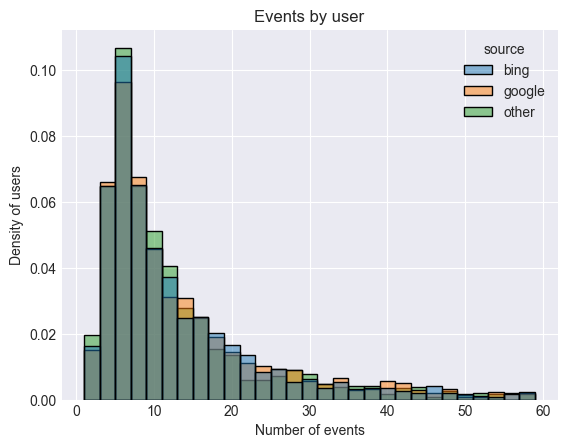

In [59]:
# mostramos el histograma de eventos por usuario por fuente
sns.histplot(
    data=event_sources_users[event_sources_users["n_events"] <= percentile],
    x="n_events",
    hue="source",
    stat="density",
    common_norm=False,
    binwidth=2,
)

plt.xlabel("Number of events")
plt.ylabel("Density of users")
plt.title("Events by user")
plt.show()

Podemos apreciar una alta superposicion de los histogramas para las 3 fuentes. Esto nos indicaria que, como intuiamos, las diferencias en la cantidad de eventos por usuario observadas anteriormente puden no ser estadisticamente significativas. De ser asi, los usuarios poseen un comportamiento equivalente (en cuanto a cantidad de eventos realizados) independiente de la fuente por la cual provengan.

Estos resultados seran validados con pruebas de hipotesis.

### Embudo

In [60]:
# mergeamos los eventos filtrados y las fuentes
events_sources = events.merge(sources, on="user_id", how="left")
events_sources.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,41,interaction_stage,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,tips_show,2019-10-07,41,entrance_stage,bing
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,advert_open,2019-10-07,41,interaction_stage,bing


In [61]:
# filtramos a los usarios provenientes de bing
events_sources_bing = events_sources[events_sources["source"] == "bing"]
events_sources_bing.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,source
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,tips_show,2019-10-07,41,entrance_stage,bing
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,advert_open,2019-10-07,41,interaction_stage,bing
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,tips_show,2019-10-07,41,entrance_stage,bing
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,advert_open,2019-10-07,41,interaction_stage,bing
11,2019-10-07 00:02:06.225301,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,tips_show,2019-10-07,41,entrance_stage,bing


In [62]:
# filtramos a los usarios provenientes de google
events_sources_google = events_sources[events_sources["source"] == "google"]
events_sources_google.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,source
37,2019-10-07 00:09:33.715659,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,tips_show,2019-10-07,41,entrance_stage,google
44,2019-10-07 00:11:48.977227,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,tips_show,2019-10-07,41,entrance_stage,google
49,2019-10-07 00:13:34.329171,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,tips_show,2019-10-07,41,entrance_stage,google
50,2019-10-07 00:13:45.388325,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,tips_show,2019-10-07,41,entrance_stage,google
57,2019-10-07 00:15:03.196647,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,tips_show,2019-10-07,41,entrance_stage,google


In [63]:
# filtramos a los usarios provenientes de otras fuentes
events_sources_other = events_sources[events_sources["source"] == "other"]
events_sources_other.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,41,interaction_stage,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,advert_open,2019-10-07,41,interaction_stage,other
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,tips_show,2019-10-07,41,entrance_stage,other


In [64]:
# seleccionamos a los usuarios de interes en bing
users_entrance_stage_bing = events_sources_bing[
    events_sources_bing["funnel_stages"] == "entrance_stage"
]["user_id"].unique()
users_interaction_stage_bing = events_sources_bing[
    events_sources_bing["funnel_stages"] == "interaction_stage"
]["user_id"].unique()
users_contact_show_bing = events_sources_bing[
    events_sources_bing["funnel_stages"] == "contacts_show"
]["user_id"].unique()

In [65]:
# obtenemos los usuarios de la interaction_stage que no hayan pasado por entrance
users_interaction_no_entrance_bing = list(
    set(users_interaction_stage_bing) - set(users_entrance_stage_bing)
)

# obtenemos los usuarios de contacts_show que no hayan pasado por interaction
users_contacts_no_interaction_bing = list(
    set(users_contact_show_bing) - set(users_interaction_stage_bing)
)

In [66]:
# obtenemos los numeros de usuarios validos en cada etapa
entrance_stage_nusers_bing = len(users_entrance_stage_bing)
interaction_stage_nusers_bing = len(users_interaction_stage_bing) - len(
    users_interaction_no_entrance_bing
)
contacts_show_nusers_bing = len(users_contact_show_bing) - len(
    users_contacts_no_interaction_bing
)

In [67]:
# seleccionamos a los usuarios de interes de google
users_entrance_stage_google = events_sources_google[
    events_sources_google["funnel_stages"] == "entrance_stage"
]["user_id"].unique()
users_interaction_stage_google = events_sources_google[
    events_sources_google["funnel_stages"] == "interaction_stage"
]["user_id"].unique()
users_contact_show_google = events_sources_google[
    events_sources_google["funnel_stages"] == "contacts_show"
]["user_id"].unique()

In [68]:
# obtenemos los usuarios de la interaction_stage que no hayan pasado por entrance
users_interaction_no_entrance_google = list(
    set(users_interaction_stage_google) - set(users_entrance_stage_google)
)

# obtenemos los usuarios de contacts_show que no hayan pasado por interaction
users_contacts_no_interaction_google = list(
    set(users_contact_show_google) - set(users_interaction_stage_google)
)

In [69]:
# obtenemos los numeros de usuarios validos en cada etapa
entrance_stage_nusers_google = len(users_entrance_stage_google)
interaction_stage_nusers_google = len(users_interaction_stage_google) - len(
    users_interaction_no_entrance_google
)
contacts_show_nusers_google = len(users_contact_show_google) - len(
    users_contacts_no_interaction_google
)

In [70]:
# graficamos los embudos para el flujo considerado
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="Google",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_google,
            interaction_stage_nusers_google,
            contacts_show_nusers_google,
        ],
        textinfo="value+percent previous",
        constraintext="outside",
    )
)

fig.add_trace(
    go.Funnel(
        name="Bing",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_bing,
            interaction_stage_nusers_bing,
            contacts_show_nusers_bing,
        ],
        textinfo="value+percent previous",
        constraintext="outside",
    )
)

fig.update_layout(legend=dict(x=0.85, y=0.05), width=950, height=500)
fig.show()

Notamos que la conversion a la interaction_stage para ambas fuentes es la misma. En contraste, la conversion de la segunda etapa a la etapa final varia bastante: 23% para google y 32% para bing. Sin embargo, si nos fijamos en la conversion final la diferencia es solo del 2% (5% para google vs 7% para bing).

Este 2%, si lo vemos de forma relativa, es una diferencia del 40% entre 5 y 7. Esto pareceria indicar que, segun el flujo considerado, podrian existir diferencias significativas entre las conversiones dependiendo de la fuente por donde provino el usuario.

Estos resultados seran validados con pruebas de hipotesis.

### Conclusiones

 Nuestras hipotesis iniciales son:
 - No existen diferencias significativas en eventos diarios entre usuarios de diversas fuentes
 - Existen diferencias significativas en conversion entre usuarios que provienen de diferentes fuentes

## Segmentacion

### Preparacion

In [71]:
# damos forma a los datos
users_events = (
    events.groupby(by=["user_id", "name"])
    .agg({"event_time": "count"})
    .reset_index()
    .pivot(index="user_id", columns="name")
    .reset_index()
)
users_events.columns = users_events.columns.get_level_values(1)
users_events.columns.name = None
users_events.rename(columns={"": "user_id"}, inplace=True)
users_events.head()

C:\Users\ayrto\AppData\Local\Temp\ipykernel_4356\2345206227.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,6,0,0,0,29
1,00157779-810c-4498-9e05-a1e9e3cedf93,2,5,11,2,0,33,18,0,0
2,00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,10,0,0,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0,0,0,6,0,17,0,4
4,00551e79-152e-4441-9cf7-565d7eb04090,0,3,3,0,0,1,1,0,0


In [72]:
# encontramos a los usarios atipicos (muchos eventos)
outliers = events_user[events_user["n_events"] > percentile]["user_id"]
outliers

1       00157779-810c-4498-9e05-a1e9e3cedf93
67      04adf25e-cb60-4cbd-bedc-ddc1057cde06
70      04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791
73      04e06319-c049-465c-9170-362a191a1287
91      05b35678-bbc6-47f0-b552-ab639249a0d4
                        ...                 
4214    fb67bbdd-f620-4d2f-b96a-cd294fa30b70
4227    fbec9791-f909-4b30-b28c-b014e3aae66a
4268    fdd232f5-962d-4eed-ac02-f0141385cc8f
4279    feb7c7a1-26e0-4ea9-9cdc-3e5b401cac97
4292    fffb9e79-b927-4dbb-9b48-7fd09b23a62b
Name: user_id, Length: 210, dtype: object

In [73]:
# descartamos a los usuarios atipicos
users_events_no_outliers = users_events[
    ~users_events["user_id"].isin(outliers)
].reset_index(drop=True)
users_events_no_outliers.head()

,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,6,0,0,0,29
1,00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,10,0,0,0
2,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0,0,0,6,0,17,0,4
3,00551e79-152e-4441-9cf7-565d7eb04090,0,3,3,0,0,1,1,0,0
4,00554293-7e00-4122-b898-4e892c4a7c53,0,0,0,0,0,0,2,0,9


In [74]:
# mergeamos las fuentes para el df completo
users_events = users_events.merge(sources, on="user_id", how="left")
users_events.head()

,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,6,0,0,0,29,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,2,5,11,2,0,33,18,0,0,bing
2,00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,10,0,0,0,bing
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0,0,0,6,0,17,0,4,google
4,00551e79-152e-4441-9cf7-565d7eb04090,0,3,3,0,0,1,1,0,0,bing


In [75]:
# mergeamos las fuentes para el df sin outliers
users_events_no_outliers = users_events_no_outliers.merge(
    sources, on="user_id", how="left"
)
users_events_no_outliers.head()

,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,6,0,0,0,29,other
1,00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,10,0,0,0,bing
2,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0,0,0,6,0,17,0,4,google
3,00551e79-152e-4441-9cf7-565d7eb04090,0,3,3,0,0,1,1,0,0,bing
4,00554293-7e00-4122-b898-4e892c4a7c53,0,0,0,0,0,0,2,0,9,bing


In [76]:
# convertimos las columnas categoricas en numericas para el df completo
users_events.set_index("user_id", inplace=True)
user_events_clustering = pd.get_dummies(users_events)
user_events_clustering.head()

,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show,source_bing,source_google,source_other
user_id,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,6,0,0,0,29,False,False,True
00157779-810c-4498-9e05-a1e9e3cedf93,2,5,11,2,0,33,18,0,0,True,False,False
00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,10,0,0,0,True,False,False
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0,0,0,6,0,17,0,4,False,True,False
00551e79-152e-4441-9cf7-565d7eb04090,0,3,3,0,0,1,1,0,0,True,False,False


In [77]:
# convertimos las columnas categoricas en numericas para el df sin outliers
users_events_no_outliers.set_index("user_id", inplace=True)
users_events_no_outliers_clustering = pd.get_dummies(users_events)
users_events_no_outliers_clustering.head()

,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show,source_bing,source_google,source_other
user_id,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,6,0,0,0,29,False,False,True
00157779-810c-4498-9e05-a1e9e3cedf93,2,5,11,2,0,33,18,0,0,True,False,False
00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,10,0,0,0,True,False,False
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0,0,0,6,0,17,0,4,False,True,False
00551e79-152e-4441-9cf7-565d7eb04090,0,3,3,0,0,1,1,0,0,True,False,False


### Estandarizacion

In [78]:
# estandatizamos sobre los datos sin outliers
sc = StandardScaler()
sc.fit(users_events_no_outliers_clustering)

# transformamos todos los datos
user_events_clustering_st = sc.transform(user_events_clustering)

### Dendograma

In [79]:
# aplicamos clustering jerarquico aglomerativo
linked = linkage(user_events_clustering_st, method="ward")

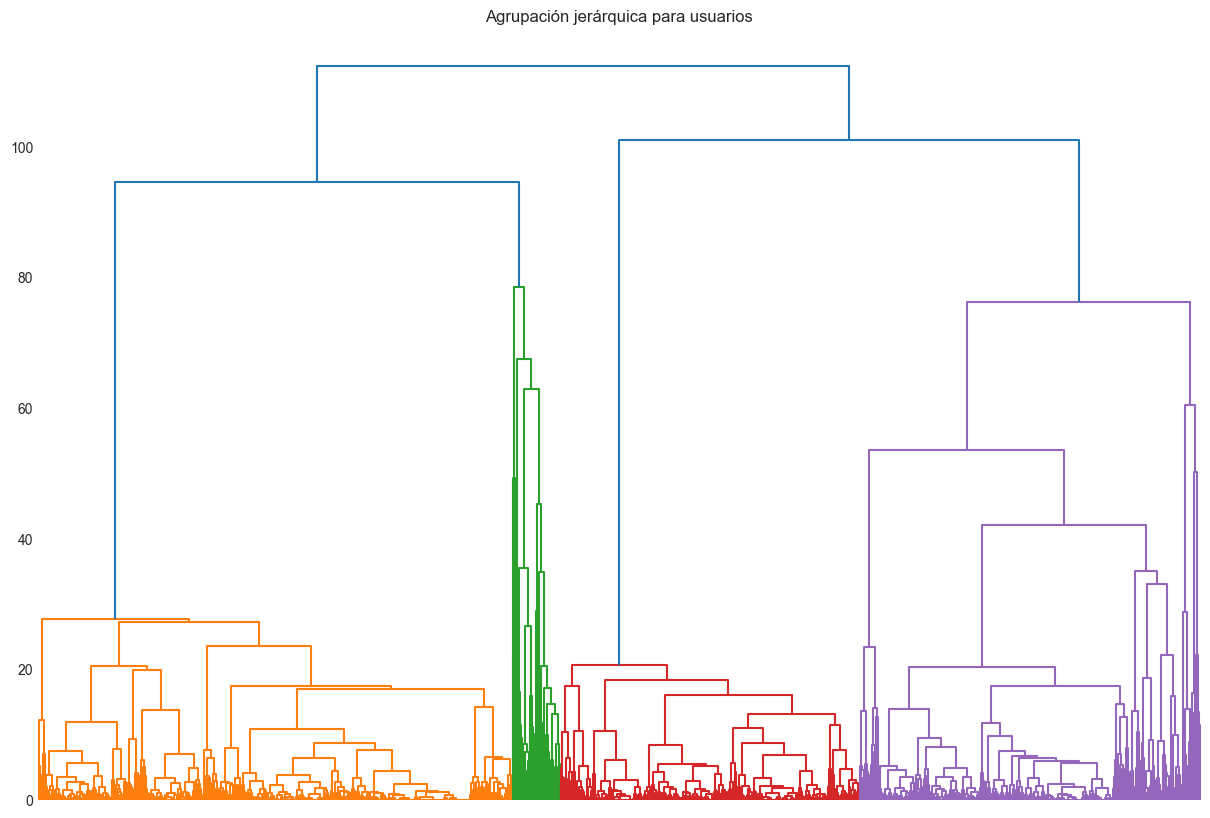

In [80]:
# graficamos el dendograma
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation="top")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

plt.title("Agrupación jerárquica para usuarios")
plt.show()

El numero recomendado de clusters 4.

### K-Means

In [81]:
# Aplicamos el algoritmo K-Means sobre los datos sin outliers
km = KMeans(n_clusters=4, random_state=42)
users_events_no_outliers_clustering_st = sc.transform(
    users_events_no_outliers_clustering
)
km.fit(users_events_no_outliers_clustering_st)

# predecimos sobre todos los datos
labels = km.predict(user_events_clustering_st)

In [82]:
# Almacenamos las etiquetas de clúster
user_events_clustering["cluster_km"] = labels

### Valores Medios

In [83]:
# Obtenemos los valores medios de las características por clúster
user_events_clustering.groupby(by="cluster_km").mean()

,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show,source_bing,source_google,source_other
cluster_km,,,,,,,,,,,,
0,22.915789,0.000000,14.378947,2.431579,10.094737,0.000000,4.242105,2.252632,90.968421,0.484211,0.284211,0.231579
1,1.115514,0.059865,0.532040,0.166105,0.629005,1.535413,1.477234,0.150084,7.189713,0.000000,0.000000,1.000000
2,2.519608,3.058824,5.245098,1.921569,0.362745,33.411765,9.784314,0.019608,1.754902,0.421569,0.362745,0.215686
3,0.827148,0.054296,0.686254,0.272509,0.735052,1.643643,1.247766,0.144330,7.803093,0.634021,0.365979,0.000000


Observamos que el cluster 0 es el grupo de usuarios que nos interesa:
 - es el que mas anuncios abre
 - es el que mas ve la informacion de contacto
 - es el que mas añade a favoritos
 - es el que mas ve el mapa
 - es el que mas busquedas realiza*
 - es el que da mas clicks en anuncios recomendados
 
Este grupo selecto de usuarios esta conformado por un 48% de usuarios que provienen de bing, un 28% de usuarios que provienen de google y un 23% de usuarios que provienen de otras fuentes.

En nuestro analisis, consideraremos dos grupos:
 - los usuarios que pertenecen al cluster 0
 - los usuarios que no pertenecen al cluster 0
 

### Eventos por dia


In [84]:
# extraemos el cluster de cada usuario
users_clusters = user_events_clustering["cluster_km"].to_frame().reset_index()
users_clusters.head()

,user_id,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
1,00157779-810c-4498-9e05-a1e9e3cedf93,2
2,00463033-5717-4bf1-91b4-09183923b9df,3
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,3
4,00551e79-152e-4441-9cf7-565d7eb04090,3


In [85]:
#  mergeamos los labels con los eventos
events_labels = events.merge(users_clusters, on="user_id", how="right")
events_labels.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,cluster_km
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1


In [119]:
# separamos a los usarios en cluster 3 y no cluster 3
cluster = 0
events_labels["cluster"] = np.where(events_labels["cluster_km"] == cluster, cluster, 1)
events_labels.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,cluster_km,cluster
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1


In [120]:
# calculamos usuarios por cluster y eventos por cluster
users_events_by_cluster = (
    events_labels.groupby(by="cluster")
    .agg({"user_id": "nunique", "event_name": "count"})
    .reset_index()
    .rename(columns={"user_id": "n_users", "event_name": "n_events"})
)
users_events_by_cluster

,cluster,n_users,n_events
0,0,95,13992
1,1,4198,60205


Podemos observar que el cluster 0 cuenta con muy pocos usuarios, pero son bastante activos!

In [121]:
# calculamos los eventos por dia
events_labels_date = (
    events_labels.groupby(by=["date", "cluster"])
    .agg({"user_id": "count"})
    .reset_index()
    .rename(columns={"user_id": "n_events"})
)
events_labels_date.head()

,date,cluster,n_events
0,2019-10-07,0,648
1,2019-10-07,1,1897
2,2019-10-08,0,602
3,2019-10-08,1,1897
4,2019-10-09,0,166


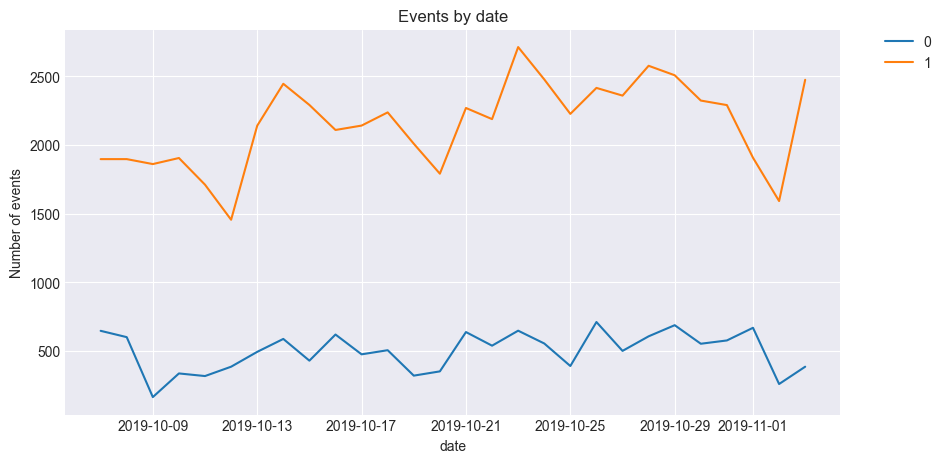

In [122]:
# graficamos cantidad de eventos por dia por fuente
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=events_labels_date,
    x="date",
    y="n_events",
    estimator="sum",
    errorbar=None,
    hue="cluster",
)

plt.ylabel("Number of events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Events by date")
plt.show()

Como no es sorpresa, los usuarios que no pertenecen al cluster 0 realizan mas eventos por dia. Esto es debido a que cuentan con mas de 4k usuarios extra.

### Eventos por usuario

In [123]:
# calculamos la cantidad de eventos de cada usuario unico
events_labels_users = (
    events_labels.groupby(by=["user_id", "cluster"])
    .agg({"name": "count"})
    .reset_index()
    .rename(columns={"name": "n_events"})
)
events_labels_users = events_labels_users.drop(
    events_labels_users[events_labels_users["n_events"] == 0].index
).reset_index(drop=True)
events_labels_users.head()

,user_id,cluster,n_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,1,71
2,00463033-5717-4bf1-91b4-09183923b9df,1,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,32
4,00551e79-152e-4441-9cf7-565d7eb04090,1,8


In [124]:
# calculamos la cantidad promedio de eventos por usuario
users_events_by_cluster["events_per_user"] = (
    users_events_by_cluster["n_events"] / users_events_by_cluster["n_users"]
)
users_events_by_cluster

,cluster,n_users,n_events,events_per_user
0,0,95,13992,147.284211
1,1,4198,60205,14.341353


Como era de esperarse, los usuarios del cluster 0 son bastante mas activos con un promedio de 147 eventos por usuario.

Los histogramas ayudaran a obtener un analisis mas profundo de lo que sucede.

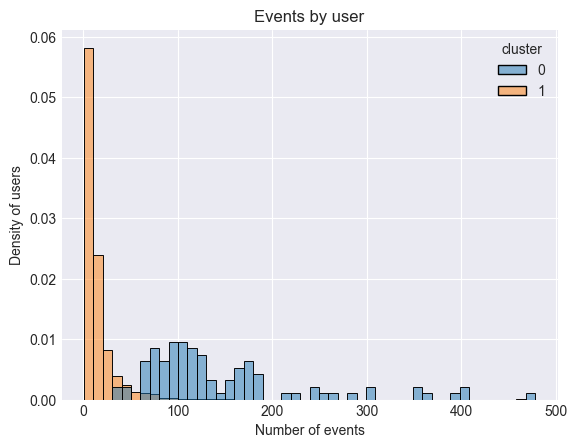

In [125]:
# mostramos el histograma de eventos por usuario por cluster
sns.histplot(
    data=events_labels_users,
    x="n_events",
    hue="cluster",
    stat="density",
    common_norm=False,
    binwidth=10,
)

plt.xlabel("Number of events")
plt.ylabel("Density of users")
plt.title("Events by user")
plt.show()

Observamos que los usuarios del cluster 0 no presentan una distribucion de eventos tan marcada como el resto de usuarios. Los demas usuarios tienen una distribucion decreciente conforme el numero de eventos aumenta. En contraste, los usuarios del cluster 0 estan repartidos sin una tendencia aparente.

Esta diferencia de comportamiento de los usuarios del cluster 0 lo hace mas dificil de comparar con respecto al resto de usuarios. Queda claro que existen diferencias notorias entre estos dos grupos. Una prueba de hipotesis lo concluira.

### Embudo

In [126]:
# filtramos a los usarios del cluster 0
events_clusters_0 = events_labels[events_labels["cluster"] == 0]
events_clusters_0.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,cluster_km,cluster
935,2019-10-13 15:41:09.088066,search_5,04adf25e-cb60-4cbd-bedc-ddc1057cde06,search,2019-10-13,41,entrance_stage,0,0
936,2019-10-13 15:41:26.669565,map,04adf25e-cb60-4cbd-bedc-ddc1057cde06,map,2019-10-13,41,map,0,0
937,2019-10-13 15:42:47.635388,tips_show,04adf25e-cb60-4cbd-bedc-ddc1057cde06,tips_show,2019-10-13,41,entrance_stage,0,0
938,2019-10-13 15:43:48.511617,advert_open,04adf25e-cb60-4cbd-bedc-ddc1057cde06,advert_open,2019-10-13,41,interaction_stage,0,0
939,2019-10-13 15:43:52.867698,tips_show,04adf25e-cb60-4cbd-bedc-ddc1057cde06,tips_show,2019-10-13,41,entrance_stage,0,0


In [127]:
# filtramos al resto de usuarios
events_clusters_n0 = events_labels[events_labels["cluster"] != 0]
events_clusters_n0.head()

,event_time,event_name,user_id,name,date,week,funnel_stages,cluster_km,cluster
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,41,entrance_stage,1,1


In [128]:
# seleccionamos a los usuarios de interes en el cluster 0
users_entrance_stage_c0 = events_clusters_0[
    events_clusters_0["funnel_stages"] == "entrance_stage"
]["user_id"].unique()
users_interaction_stage_c0 = events_clusters_0[
    events_clusters_0["funnel_stages"] == "interaction_stage"
]["user_id"].unique()
users_contact_show_c0 = events_clusters_0[
    events_clusters_0["funnel_stages"] == "contacts_show"
]["user_id"].unique()

In [129]:
# obtenemos los usuarios de la interaction_stage que no hayan pasado por entrance
users_interaction_no_entrance_c0 = list(
    set(users_interaction_stage_c0) - set(users_entrance_stage_c0)
)

# obtenemos los usuarios de contacts_show que no hayan pasado por interaction
users_contacts_no_interaction_c0 = list(
    set(users_contact_show_c0) - set(users_interaction_stage_c0)
)

In [130]:
# obtenemos los numeros de usuarios validos en cada etapa
entrance_stage_nusers_c0 = len(users_entrance_stage_c0)
interaction_stage_nusers_c0 = len(users_interaction_stage_c0) - len(
    users_interaction_no_entrance_c0
)
contacts_show_nusers_c0 = len(users_contact_show_c0) - len(
    users_contacts_no_interaction_c0
)

In [131]:
# seleccionamos a los usuarios de interes en el resto de clusters
users_entrance_stage_nc0 = events_clusters_n0[
    events_clusters_n0["funnel_stages"] == "entrance_stage"
]["user_id"].unique()
users_interaction_stage_nc0 = events_clusters_n0[
    events_clusters_n0["funnel_stages"] == "interaction_stage"
]["user_id"].unique()
users_contact_show_nc0 = events_clusters_n0[
    events_clusters_n0["funnel_stages"] == "contacts_show"
]["user_id"].unique()

In [132]:
# obtenemos los usuarios de la interaction_stage que no hayan pasado por entrance
users_interaction_no_entrance_nc0 = list(
    set(users_interaction_stage_nc0) - set(users_entrance_stage_nc0)
)

# obtenemos los usuarios de contacts_show que no hayan pasado por interaction
users_contacts_no_interaction_nc0 = list(
    set(users_contact_show_nc0) - set(users_interaction_stage_nc0)
)

In [133]:
# obtenemos los numeros de usuarios validos en cada etapa
entrance_stage_nusers_nc0 = len(users_entrance_stage_nc0)
interaction_stage_nusers_nc0 = len(users_interaction_stage_nc0) - len(
    users_interaction_no_entrance_nc0
)
contacts_show_nusers_nc0 = len(users_contact_show_nc0) - len(
    users_contacts_no_interaction_nc0
)

In [145]:
# graficamos el embudo para el cluster 0
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="Cluster 0",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_c0,
            interaction_stage_nusers_c0,
            contacts_show_nusers_c0,
        ],
        textinfo="value+percent previous",
    )
)


fig.update_layout(legend=dict(x=0.85, y=0.05), width=950, height=500)
fig.show()

In [135]:
# graficamos el embudo para los demas clusters
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="Not Cluster 3",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_nc0,
            interaction_stage_nusers_nc0,
            contacts_show_nusers_nc0,
        ],
        textinfo="value+percent previous",
    )
)


fig.update_layout(legend=dict(x=0.85, y=0.05), width=950, height=500)
fig.show()

### Conclusiones

Con este analisis inicial presentado, podemos observar que existe una diferencia significativa entre el comportamiento de los usuarios del cluster 0 en comparacion con los demas usuarios. 

Estas diferencias observadas intuimos que se traduciran en valores distintos para las metricas de cada grupo. Esto sera validado con las pruebas de hipotesis.

## Pruebas de Hipotesis
 - diferencias por fuente: cantidad de eventos por usuario y conversion
 - diferencias por cluster: cantidad de eventos por usuario y conversion

### Diferencias por fuente - eventos por usuario

 - Ho: La cantidad de eventos por usuario es la misma independiente de la fuente por donde proviene
 - H1: La cantidad de eventos por usuario varia segun la fuente de donde provienen
 - alpha: nivel de significacion, probabilidad de cometer un error tipo 1, 5%

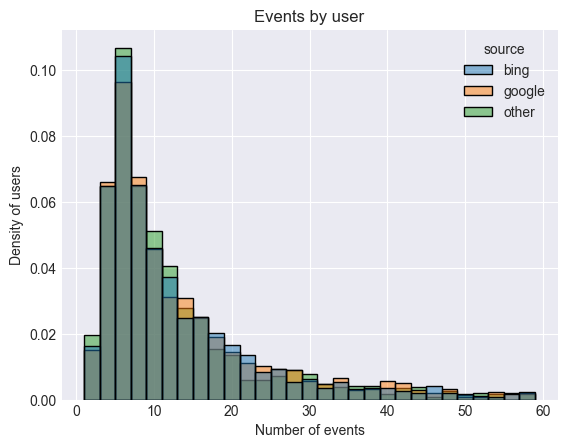

In [103]:
# mostramos el histograma de eventos por usuario por fuente
sns.histplot(
    data=event_sources_users[event_sources_users["n_events"] <= percentile],
    x="n_events",
    hue="source",
    stat="density",
    common_norm=False,
    binwidth=2,
)

plt.xlabel("Number of events")
plt.ylabel("Density of users")
plt.title("Events by user")
plt.show()

Podemos ver que las muestras son muy similares no presentan una distribucion normal. De todas maneras aplicaremos un test de Shapiro-Wilk

In [104]:
# Separamos los datos para usuarios provenientes de bing
event_sources_users_bing = event_sources_users[
    (event_sources_users["n_events"] <= percentile)
    & (event_sources_users["source"] == "bing")
]
event_sources_users_bing.head()

,user_id,source,n_events
2,00463033-5717-4bf1-91b4-09183923b9df,bing,10
4,00551e79-152e-4441-9cf7-565d7eb04090,bing,8
5,00554293-7e00-4122-b898-4e892c4a7c53,bing,11
6,005fbea5-2678-406f-88a6-fbe9787e2268,bing,5
8,006a32d4-ee10-40dc-b237-11e0fde81cbc,bing,6


In [105]:
# Separamos los datos para usuarios provenientes de google
event_sources_users_google = event_sources_users[
    (event_sources_users["n_events"] <= percentile)
    & (event_sources_users["source"] == "google")
]
event_sources_users_google.head()

,user_id,source,n_events
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,32
7,00653802-5ff1-4071-bc17-347fc4cef569,google,5
13,00a93a72-3bbc-4ee7-8a81-7134f45ae009,google,15
15,00af35c4-2045-4960-96b8-7fd5f1978a88,google,5
21,01147bf8-cd48-49c0-a5af-3f6eb45f8262,google,30


In [106]:
# aplicamos el test de normalidad de Shapiro-Wilk
res_shapiro_google = st.shapiro(event_sources_users_google["n_events"])
res_shapiro_bing = st.shapiro(event_sources_users_bing["n_events"])

print("p-value (Google): ", res_shapiro_google.pvalue)
print("p-value (Bing): ", res_shapiro_bing.pvalue)

p-value (Google):  1.0415312462176789e-34
p-value (Bing):  1.1776978578017968e-43


In [107]:
# aplicamos la prueba de hipotesis
alpha = 0.05
n = 2
# correccion de bonferrini
alpha_shapiro = alpha / n

print("Hipotesis nula: las muestras provienen de distribuciones normales")

if (res_shapiro_google.pvalue < alpha_shapiro) & (
    res_shapiro_bing.pvalue < alpha_shapiro
):
    print(
        "Se rechaza la hipotesis nula: las muestras NO provienen de distribuciones normales"
    )
else:
    print("No se pudo rechazar la hipotesis nula")

Hipotesis nula: las muestras provienen de distribuciones normales
Se rechaza la hipotesis nula: las muestras NO provienen de distribuciones normales


In [108]:
# aplicamos el test de mann-whitney
results = st.mannwhitneyu(
    event_sources_users_google["n_events"], event_sources_users_bing["n_events"]
)

print("p-value: ", results.pvalue)
if results.pvalue < alpha:
    print(
        "Se rechaza la hipotesis nula: la cantidad de eventos por usuario varia en funcion a la fuente"
    )
else:
    print("No se puede rechazar la hipotesis nula")

p-value:  0.4329154463942062
No se puede rechazar la hipotesis nula


Como intuimos desde un comienzo, los histogramas para la cantidad de eventos por usuario son muy similares de una fuente a otra. Esto nos daba el indicio de que no existen diferencias en esta metrica con respecto a la fuente. Hemos podido corroborar nuestra hipotesis inicial con un test de mann-whitney.

### Diferencias por fuente - Conversion

 - Ho: La conversion es la misma independiente de la fuente por donde proviene el usuario
 - H1: La conversion varia segun la fuente de donde provienen los usuarios
 - alpha: nivel de significacion, probabilidad de cometer un error tipo 1, 5%

In [109]:
# graficamos los embudos para el flujo considerado
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="Google",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_google,
            interaction_stage_nusers_google,
            contacts_show_nusers_google,
        ],
        textinfo="value+percent initial",
        constraintext="outside",
    )
)

fig.add_trace(
    go.Funnel(
        name="Bing",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_bing,
            interaction_stage_nusers_bing,
            contacts_show_nusers_bing,
        ],
        textinfo="value+percent initial",
    )
)

fig.update_layout(legend=dict(x=0.85, y=0.05), width=950, height=500)
fig.show()

Recordamos que las conversiones finales para cada fuente son del 5% para Google y del 7% para Bing.

In [110]:
# ejecutamos la prueba para la conversion entrance_stage -> contacts_show
evento_inicial = "entrance_stage"
evento_final = "contacts_show"

# cantidad inicial de usuarios para cada fuente
n_Google = entrance_stage_nusers_google
n_Bing = entrance_stage_nusers_bing

# proporcion de usuarios para cada fuente
p_Google = contacts_show_nusers_google / n_Google
p_Bing = contacts_show_nusers_bing / n_Bing

# proporcion combinada
p_comb = (contacts_show_nusers_google + contacts_show_nusers_bing) / (n_Google + n_Bing)

# diferencia de proporciones
p_diff = p_Bing - p_Google

z = p_diff / mth.sqrt(p_comb * (1 - p_comb) * (1 / n_Google + 1 / n_Bing))
distr = st.norm(0, 1)

# prueba de dos colas
p_value = (1 - distr.cdf(abs(z))) * 2

print("Prueba {} -> {}".format(evento_inicial, evento_final))
print("p-value: ", p_value)

if p_value < alpha:
    print("Se rechaza la hipotesis nula: la conversion varia en funcion a la fuente")
else:
    print("No se puede rechazar la hipotesis nula")

Prueba entrance_stage -> contacts_show
p-value:  0.06107037820317318
No se puede rechazar la hipotesis nula


In [111]:
p_diff

0.01843647735068473

Observamos que con un p-value del 6%, decidimos no rechazar la hipotesis nula. Es decir, consideramos que no existe una diferencia entre las conversiones de los usuarios con respecto a la fuente.

Si bien esto se podia intuir dadas la pequenha diferencia absoluta en conversiones (5% vs 7%), la diferencia relativa no nos permitia poder concluirlo. Estos resultados son dan una mayor luz y permiten dar firmeza en nuestro analisis al concluir que no hay diferencias signicativas en terminos de conversion entre usuarios de Bing y Google.

Debemos acotar de tomas maneras que en este caso los tamanos de muestra tienen una diferencia considerable (aprox.60%). Sin embargo, se cuentan con datos suficientes por ambos lados (aprox. 1k) como para tener confianza en los resultados obtenidos.

### Diferencias por cluster - eventos por usuario

 - Ho: La cantidad de eventos por usuario es la misma independiente del cluster al que pertenece el usuario
 - H1: La cantidad de eventos por usuario varia segun el cluster al que pertenece el usuario
 - alpha: nivel de significacion, probabilidad de cometer un error tipo 1, 5%

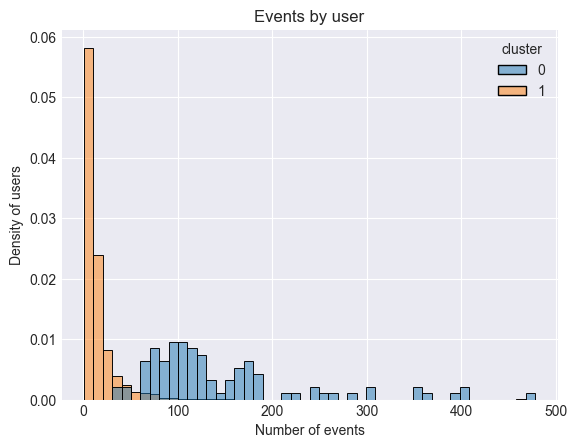

In [136]:
# mostramos el histograma de eventos por usuario por cluster
sns.histplot(
    data=events_labels_users,
    x="n_events",
    hue="cluster",
    stat="density",
    common_norm=False,
    binwidth=10,
)

plt.xlabel("Number of events")
plt.ylabel("Density of users")
plt.title("Events by user")
plt.show()

Esta vez decidimos no aplicar un test de Shapiro-Wilk y procederemos con el Mann-Whitney.

In [140]:
# separamos los datos para los usuarios del cluster 0
events_labels_users_c0 = events_labels_users[events_labels_users["cluster"] == 0]
events_labels_users_c0.head()

,user_id,cluster,n_events
67,04adf25e-cb60-4cbd-bedc-ddc1057cde06,0,110
70,04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791,0,170
108,06bdb96e-2712-47b3-a0af-d19f297abd6c,0,138
122,07a043c4-8168-4691-88ce-7b3c563432d2,0,97
181,0a59892f-3578-484b-af84-eb3b2298fb8c,0,65


In [141]:
# separamos los datos para el resto de usuarios
events_labels_users_nc0 = events_labels_users[events_labels_users["cluster"] != 0]
events_labels_users_nc0.head()

,user_id,cluster,n_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,1,71
2,00463033-5717-4bf1-91b4-09183923b9df,1,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,32
4,00551e79-152e-4441-9cf7-565d7eb04090,1,8


In [142]:
# aplicamos el test de mann-whitney
results = st.mannwhitneyu(
    events_labels_users_c0["n_events"], events_labels_users_nc0["n_events"]
)

print("p-value: ", results.pvalue)
if results.pvalue < alpha:
    print(
        "Se rechaza la hipotesis nula: la cantidad de eventos por usuario varia en funcion al cluster"
    )
else:
    print("No se puede rechazar la hipotesis nula")

p-value:  3.3596040048657165e-61
Se rechaza la hipotesis nula: la cantidad de eventos por usuario varia en funcion al cluster


Como era de esperar, los comportamientos de los usuarios eran demasiado distintos como para considerar que no existe una diferencia con respecto al cluster de pertenencia. Esta prueba de Mann-Whitney nos confirma lo que ya observavamos: los usuarios del cluster 0 presentan una mayor cantidad de eventos por usuario.

### Diferencias por cluster - Conversion

 - Ho: La conversion es la misma independiente del cluster al que pertenece el usuario
 - H1: La conversion varia segun el cluster al que pertenece el usuario
 - alpha: nivel de significacion, probabilidad de cometer un error tipo 1, 5%

In [143]:
# graficamos el embudo para el cluster 3
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="Cluster 0",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_c0,
            interaction_stage_nusers_c0,
            contacts_show_nusers_c0,
        ],
        textinfo="value+percent initial",
    )
)

fig.update_layout(legend=dict(x=0.85, y=0.05), width=950, height=500)
fig.show()

In [144]:
# graficamos el embudo para los demas clusters
fig = go.Figure()

fig.add_trace(
    go.Funnel(
        name="Not Cluster 3",
        y=["entrance_stage", "interaction_stage", "contacts_show"],
        x=[
            entrance_stage_nusers_nc0,
            interaction_stage_nusers_nc0,
            contacts_show_nusers_nc0,
        ],
        textinfo="value+percent initial",
    )
)


fig.update_layout(legend=dict(x=0.85, y=0.05), width=950, height=500)
fig.show()

Recordamos que las conversiones para el evento destino son de 45% para el cluster 0 vs 5% para el resto de clusters.

In [146]:
# ejecutamos la prueba para la conversion entrance_stage -> contacts_show
evento_inicial = "entrance_stage"
evento_final = "contacts_show"

# cantidad inicial de usuarios para cada fuente
n_c0 = entrance_stage_nusers_c0
n_nc0 = entrance_stage_nusers_nc0

# proporcion de usuarios para cada fuente
p_c0 = contacts_show_nusers_c0 / n_c0
p_nc0 = contacts_show_nusers_nc0 / n_nc0

# proporcion combinada
p_comb = (contacts_show_nusers_c0 + contacts_show_nusers_nc0) / (n_c0 + n_nc0)

# diferencia de proporciones
p_diff = p_nc0 - p_c0

z = p_diff / mth.sqrt(p_comb * (1 - p_comb) * (1 / n_c0 + 1 / n_nc0))
distr = st.norm(0, 1)

# prueba de dos colas
p_value = (1 - distr.cdf(abs(z))) * 2

print("Prueba {} -> {}".format(evento_inicial, evento_final))
print("p-value: ", p_value)

if p_value < alpha:
    print("Se rechaza la hipotesis nula: la conversion varia en funcion del cluster")
else:
    print("No se puede rechazar la hipotesis nula")

Prueba entrance_stage -> contacts_show
p-value:  0.0
Se rechaza la hipotesis nula: la conversion varia en funcion del cluster


Como observamos en los embudos, la diferencia en conversiones es abismal (45% vs 5%). No cabe duda que la conversion varia en funcion al cluster al que pertenece el usuario.

Este resultado puede considerarse medianamente esperado desde el momento del disenho del problema. Segmentar a usuarios por clusters implica que aquellos usuarios con comportamientos similares sean agrupados, esto incluye a los usuarios que llegan al evento denstimo. Es sencillo intuir que uno de los clusteres pueda tener muchos usuarios que convierten, en comparacion al resto de clusters. Al dividir en dos grupos nos quedamos con: un grupo con una alta conversion y un grupo con una baja conversion. Es de esperar que una prueba de hipotesis nos confirme aquello que nuestro algoritmo fue disenado para hacer.

Sin embargo, cabe recalcar que esto implica que si el numero de usuarios que convierte es bajo para toda la muestra, el cluster que contiene a estos usuarios tambien tendra un numero bajo de integrantes. Es decir, estamos trabajando con muestras pequeñas y por ende nuestros resultados, si bien correctos, deben interpretarse cuidadosamente.

### Conclusiones

 - No se pudieron encontrar diferencias en conversion ni eventos por dia entre usuarios provenientes de Bing comparados contra Google
   - Se confirma una hipotesis inicial
   - Se rechaza una hipotesis inicial
 - Se pudieron encotrar diferencias tanto en conversion como en eventos diarios entre usuarios que pertenecen al cluster 0 comparados con el resto de usuarios
   - Se confirman ambas hipotesis 
 - Se recalca que la conclusion anterior fue obtenida con pocos datos (poco mas de 90 integrantes del cluster 0)

## Conclusion

- Se ejecuto correctamete el plan de accion
- No se encontraron ni duplicados ni ausentes en los datos
- Se hizo uso de tipos de dato mas apropiados
- El usuario promedio realiza entre 3 a 8 eventos
- Solo el 6% de los usuarios convierten al evento destino (contacts_show)
- Nuestras hipotesis iniciales son que no existen diferencias en eventos diarios por tipo de fuente, mas si existen diferencias en conversion
- Nuestra hipotesis luego de la segmentacion es que existen diferenias tanto en eventos diarios como en conversion entre los usuarios del cluster 0 comparados con el resto de usuarios
- Las pruebas de hipotesis confirman que no existen diferencias en eventos diarios por tipo de fuente, mas rechazan que existan diferencias en conversion
- Las pruebas de hipotesis confirman que existen diferencias tanto en en eventos diarios como en conversion entre usuarios que pertenecen al cluster 0 con respecto al resto de usuarios

## Dashboard

Conforme a lo indicado, en estas lineas comunico que deseo elaborar un dashboard. Siendo este item opcional (mas el escogido para llegar a los 8 SP, y por tanto requerido), procedo a entregar mi proyecto ANTES de haber culminado el dashboard. Hago esto para poder conseguir el feedback lo antes posible, mientras trabajo en el dashboard. 

Dicho esto, desconozco si cuando se revise mi proyecto el dashboard estara o no completado. De todas maneras, todo será subido al link de drive presentado al comienzo de este notebook.

Entiendo que el dashboard debe estar completado para que se apruebe el proyecto. Si se diese el caso de que el proyecto es revisado y no se requieren mayores cambios para su aprobacion, pero el dashboard no ha sido implementado aun (y por ende no se encuentra en el link); agradecería se me comunique dentro de la revisión del proyecto que solo eso falta para su aprobación. En caso se requieran cambios (adicionales al dashboard), entiendo el flujo sería de todas maneras el antes solicitado.

Sin mas que agregar, en el link encontrarán este notebook (meta), la presentación, y (eventualmente) el dashboard.

Muchas gracias!